In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from parameters import read_params

from scipy.special import gamma
def myGamma(zeta):
    return gamma(1-1/zeta)

DIR = r"/home/cz/Dropbox/Summer RA Model EP/Parameters/"

def pv(name, mat):
    print("{}: {}".format(name.rjust(10), mat.shape))

In [2]:
param = read_params()

Found 13 parameters
param.beta = 0.28818
param.q = 0.67565
param.mu = 3.4112
param.zeta = 1.62
param.alpha = 0.05
param.sigma = 4
param.psi = 0.76551
param.delta = 0.91803
param.eta = 0.35
param.gamma = 0.35055
param.nu = 0.0187
param.kappa = 0.42
param.r = 2.8866

 skill1880: (645, 2)
  wage1880: (645, 2)
       Q_A: (645, 5)
      Q_NA: (645, 5)
         Z: (5, 2)
        vA: (5, 1)
   Capital: (5, 1)
       phi: (4, 1)
       tau: (645, 645)
 amenities: (645, 5)


## Interest rate functions

In [3]:
def psi(r):
    n = param.eta
    ret = 1 + (param.beta**(1/(1-n))) * ((1+r)**(n/(1-n)))
    return 1/ret

$$
r = R - \delta
$$

In [4]:
psi(param.r)

0.7655096595807223

In [5]:
myGamma(param.zeta)

2.3211529336709016

## Reshaping..

In [6]:
# now this is just for the short names
skills, wages = param.skill1880, param.wage1880
Q_A, Q_NA = param.Q_A, param.Q_NA

Z, vA, Capital, phi = param.Z, param.vA, param.Capital, param.phi

tau, amenities = param.tau.T, param.amenities

In [7]:
# TODO MAKE 4 DIMENSIONS (time, skill, sector, region)

skills = np.expand_dims(skills, 2).transpose((2,1,0))
pv("skills", skills)

wages = np.expand_dims(wages, 2).transpose((2,1,0))
pv("wages", wages)

Q = np.stack((Q_A, Q_NA), axis=1).transpose((2,1,0))
pv("Q", Q)

vA = vA.flatten()
vAt= np.array([vA[1], 1-vA[1]]).reshape(2,1)
pv("vAt", vAt)

Capital = Capital.flatten()
pv("Capital", Capital)

pv("tau", tau)

amenities = amenities.transpose((1,0))
pv("amenities", amenities)

    skills: (1, 2, 645)
     wages: (1, 2, 645)
         Q: (5, 2, 645)
       vAt: (2, 1)
   Capital: (5,)
       tau: (645, 645)
 amenities: (5, 645)


In [8]:
vAt

array([[0.32289],
       [0.67711]])

In [9]:
# define some constants for indexing
t = 0
A, NA = 0,1
L, H = 0,1
R,S,T = 2,1,0

# Remember that Psi is indexed like Psi[L,A]
Psi = np.array([[1,1],
                [param.q, param.mu * param.q]])

## Define methods

In [10]:
# useful for resets
def readWages():
    wages = param.wage1880
    wages = np.expand_dims(wages, 2).transpose((2,1,0))
    wages = wages / np.sum(wages) # what if we normalize for fun
    return wages

def readSkills():
    skills = param.skill1880
    skills = np.expand_dims(skills, 2).transpose((2,1,0))
    return skills

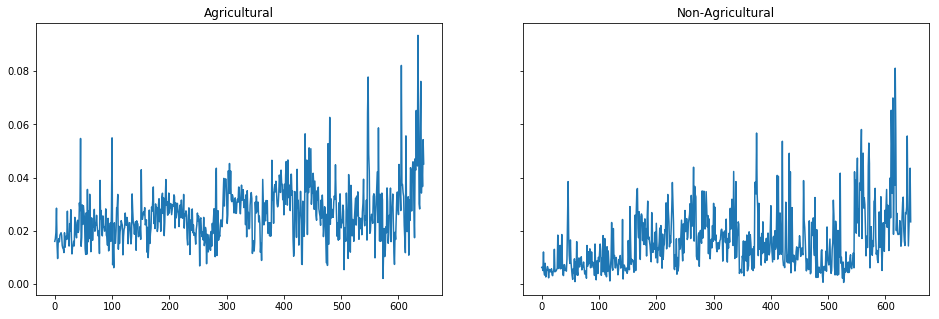

In [11]:
# useful for plotting
plot_params = {
    'alpha': 0.4,
    's': 4
}

def drawLog(wages):
    plt.scatter(np.log(wages[t,A]), np.log(wages[t,NA]),
           **plot_params)

def draw(wages):
    plt.scatter(wages[t,A], wages[t,NA],
           **plot_params)

def plotANA(x):
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(16,5))
    
    ax1.plot(x[t,A])
    ax1.set_title("Agricultural")
    
    ax2.plot(x[t,NA])
    ax2.set_title("Non-Agricultural")
    
plotANA(wages)

## $\pi_{rst}$

In [12]:
def computePi(wages):
    """
    Parameters:
        wages - shape [time, Sectors, Regions]
        Q - shape [time, Sectors, Regions]
    
    Returns:
        pi has shape (1, 2, 645)
    """
    # Q is already raised**(sigma - 1)
    pi = Q[1] * wages**((1-param.alpha)*(1-param.sigma)) # use 1910 Q's
    
    # sum across regions
    normalize = np.sum(pi, axis=R)
    
    # normalize has shape (1,2), so we make it have shape (1,2,1)
    normalize = np.expand_dims(normalize, axis=2)
    pi = pi / normalize
    
    return pi

pi = computePi(wages)
np.sum(pi, axis=R)

array([[1., 1.]])

In [13]:
pi.shape

(1, 2, 645)

## $\Theta^h_{rt}$

In [14]:
def computeTheta(wages):
    """
    196 µs ± 1.95 µs per loop (mean ± std. dev. of 7 runs)
    """
    Theta = np.matmul(Psi, wages**(param.zeta)) ** (1/param.zeta)
    Theta_l = Theta[0,L]
    Theta_h = Theta[0,H]
    return Theta_h, Theta_l

def computeTheta2(wages):
    """
    304 µs ± 2.88 µs per loop (mean ± std. dev. of 7 runs,
    """
    z = param.zeta
    Theta_h = (Psi[H,A]*(wages[t,A]**z) + Psi[H,NA]*(wages[t,NA]**z))**(1/z)
    Theta_l = (Psi[L,A]*(wages[t,A]**z) + Psi[L,NA]*(wages[t,NA]**z))**(1/z)
    return Theta_h, Theta_l

a,b = computeTheta(wages)
c,d = computeTheta2(wages)

np.sum(a-c), np.sum(b-d) # these are the same

(0.0, 0.0)

# $\lambda$ and $L$

In [15]:
def computeLrt(skills):
    """
    Expects:
        skills[1,2,645]
        skills[0, L, :] == low-skilled populations across regions
    
    Returns:
        const_lambda - Lambda, 1-Lambda. This is constant throughout time
        totals - L. (portion of population in each region)
        skill_shares - share of high/low skill in each region. lambda_rt and 1-lambda_rt
        
    """
    const_lamda = np.sum(skills, axis=R)
    sums = np.sum(skills, axis=S)
    skill_shares = (skills/sums)
    return const_lamda, sums, skill_shares

def test_computeLrt(skills):
    const_lamda, sums, skill_shares = computeLrt(skills)

    print(const_lamda)
    print('L_rt sums to', np.sum(sums))
    
    x = np.sum(skill_shares, axis=S)
    print(np.allclose(x, np.ones_like(x)))
    
test_computeLrt(skills)

[[0.7046579  0.29534209]]
L_rt sums to 0.999999993419246
True


The majorit of commuting zones had agricultural employment shares exceeding 75% in 1880...

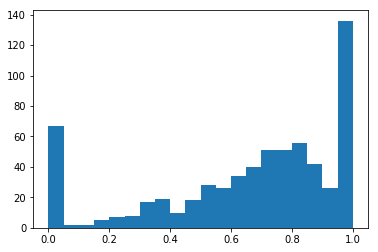

In [16]:
const_lamda, sums, skill_shares = computeLrt(skills)

plt.hist(skill_shares[t,L], bins=20)
plt.show()

In [17]:
np.sum(skills)

0.9999999934192461

## GDP

In [18]:
skills, wages = readSkills(), readWages()

def computeGDP(skills, wages):
    """
    GDP is an actual number!
    """
    Theta_h, Theta_l = computeTheta(wages)
    
    constant= 1/(1-param.alpha) * myGamma(param.zeta)
    GDP = constant * np.sum((skills[t,H] * Theta_h + skills[t,L] * Theta_l))
    
    return GDP

computeGDP(skills, wages)

0.0034030779422166675

## Sectoral prices (and normalizing wages)

In [19]:
param.Z

array([[0.045844, 0.051099],
       [0.067368, 0.084494],
       [0.098668, 0.15938 ],
       [0.083907, 0.27512 ],
       [0.11267 , 0.48463 ]])

In [20]:
R_t = 3.63

In [21]:
Zt = param.Z[1]
Zt.shape

sector = NA

temp = Q[t,sector,0] * ((1/Zt[sector] * (wages[t,sector,0] / (1-param.alpha))**(1-param.alpha)* (R_t/param.alpha)**param.alpha))**(1-param.sigma)
temp

26.592781960829953

In [22]:
x = Q[t].transpose((1,0)) * (1/Zt * (wages[t].transpose((1,0)) / (1-param.alpha))**(1-param.alpha)* (R_t/param.alpha)**param.alpha)**(1-param.sigma)
x = x.transpose((1,0))
x.shape

x[sector, 0]

26.592781960829953

In [23]:
prices = np.sum(x, axis=1)**(1/(1-param.sigma))
prices # P_A, P_NA

array([0.01625318, 0.02607759])

In [24]:
# and then we normalize it
normprices = prices/prices[0]
normprices

array([1.        , 1.60446064])

What price normalization means for wages:
$$
P_{At} = \Big(\sum_j \Big( stuff \cdot \big(\frac{w_{Ajt}}{1-\alpha}\big)^{1-\alpha} \Big)^{1-\sigma} \Big)^{\frac{1}{1-\sigma}}
$$

$$
1 = \Big(\sum_j \Big( stuff \cdot \big(\frac{w_{Ajt}}{1-\alpha}\big)^{1-\alpha} \cdot P_{At}^{-1} \Big)^{1-\sigma} \Big)^{\frac{1}{1-\sigma}}
$$

$$
1 = \Big(\sum_j \Big( stuff \cdot \big(\frac{ w_{Ajt} \cdot P_{At}^{-\frac{1}{1-\alpha}}}{1-\alpha}\big)^{1-\alpha} \Big)^{1-\sigma} \Big)^{\frac{1}{1-\sigma}}
$$

Or equivalently:
$$
w_{new} = \frac{ w_{old}}{ P_{At}^{\frac{1}{1-\alpha}}}
$$

In [25]:
normwages = wages/(prices[0]**(1/(1-param.alpha)))
normwages

array([[[0.04492427, 0.0476596 , 0.05415494, ..., 0.10259006,
         0.15191269, 0.12633727],
        [0.01759091, 0.01745988, 0.0142794 , ..., 0.07859928,
         0.12191091, 0.0654602 ]]])

In [26]:
# just be careful: if we do it this way, the wages will be great!
np.sum(normwages, axis=R)

array([[47.74604072, 28.67673111]])

In [27]:
def priceNormalize(wages):
    """
    Sets the price of the agricultural good to 1
    
    Parameters:
        Q_rst
        Z_st
        param.alpha
        R_t
        
    Returns:
        normalized wages
    """
    Zt = param.Z[1]
    x = Q[1].transpose((1,0)) * (1/Zt * (wages[t].transpose((1,0)) / (1-param.alpha))**(1-param.alpha)* (R_t/param.alpha)**param.alpha)**(1-param.sigma)
    x = x.transpose((1,0))
    prices = np.sum(x, axis=1)**(1/(1-param.sigma))
    normprices = prices/prices[NA]

    wages = wages * ((1/prices[NA])**(1/(1-param.alpha)))
    return wages

In [28]:
import pandas as pd
import os

myfile = os.path.join(DIR, '{}.csv'.format('w1910'))
mat = pd.read_csv(myfile, header=None).values
real1910Wages = mat

real1910Wages = np.expand_dims(real1910Wages, 2).transpose((2,1,0))
real1910Wages.shape

(1, 2, 645)

In [29]:
def computePrices(wages):
    Zt = param.Z[1]
    x = Q[1].transpose((1,0)) * (1/Zt * (wages[t].transpose((1,0)) / (1-param.alpha))**(1-param.alpha)* (R_t/param.alpha)**param.alpha)**(1-param.sigma)
    x = x.transpose((1,0))
    prices = np.sum(x, axis=1)**(1/(1-param.sigma))
    return prices

In [30]:
computePrices(real1910Wages)

array([0.89383011, 0.99765761])

## Part 1: Testing the wage loop

In [31]:
vAt, vAt.shape

(array([[0.32289],
        [0.67711]]), (2, 1))

In [32]:
def logNorm(name, *args, precision=4):
    sums = [round(np.sum(a**2), precision) for a in args]
    print(name, sums)

logNorm("check", wages, skills)

check [0.001, 0.005]


In [33]:
wages = readWages()

lr = 0.03

# these are fixed
const_lamda, sums, skill_shares = computeLrt(skills)

previous_newWages = wages
for i in range(300):
    # normalize wages BY THE PRICE OF THE AGRICULTURAL GOOD

    wages = priceNormalize(wages)

    # compute the update
    pi = computePi(wages) # (1 by 2 by 645)
    Theta_h, Theta_l = computeTheta(wages) # (645,)
    GDP = computeGDP(skills, wages)
    revenue = (1-param.alpha) * pi * vAt * GDP
    GDP

    #  labor market clearing conditions

    # A
    s_hA = Psi[H,A] * (wages[t,A] / Theta_h)**(param.zeta)
    s_lA = Psi[L,A] * (wages[t,A] / Theta_l)**(param.zeta)

    # NA
    s_hNA = Psi[H,NA] * (wages[t,NA] / Theta_h)**(param.zeta)
    s_lNA = Psi[L,NA] * (wages[t,NA] / Theta_l)**(param.zeta)
    
    # w*(H_highskill + H_lowskill) == left hand side (for a given sector)
    zeta = param.zeta
    H_hA = skills[t,H] * (Psi[H,A]**(1/zeta)) * (s_hA**(1-1/zeta))
    H_hNA = skills[t,H] * (Psi[H,NA]**(1/zeta)) * (s_hNA**(1-1/zeta))
    H_lA = skills[t,L] * (Psi[L,A]**(1/zeta)) * (s_lA**(1-1/zeta))
    H_lNA = skills[t,L] * (Psi[L,NA]**(1/zeta)) * (s_lNA**(1-1/zeta))
    
    x_A = H_hA + H_lA
    x_NA= H_hNA + H_lNA
    
    newWages = revenue / np.vstack([x_A, x_NA])
    
    loss = np.sum((newWages - previous_newWages)**2)
    previous_newWages = newWages
    
    wages = lr * newWages + (1-lr) * wages

    if loss < 1e-7:
        print('w-- #{}: {}'.format(i, loss))
        break

    if i%20 == 0:
        print(i, np.sum(newWages), np.sum(wages), loss)

0 4639.729299322291 214.1719663065519 1586825.8172960219
20 130.20849839615224 76.44291275102891 0.003386176278048268
40 131.35952515841856 62.344282035947955 0.0011207040894481827
60 131.52163210843094 59.637307076804504 0.0003808562836943775
80 131.99759233525126 59.19523238933385 6.9677637074599645e-06
100 132.06277516481438 59.15322214528069 9.998141837022109e-07
w-- #105: 5.851565277978253e-08


In [34]:
def loopy(skills, wages, log=True):

    lr = 0.03

    # these are fixed
    const_lamda, sums, skill_shares = computeLrt(skills)

    previous_newWages = wages
    for i in range(300):
        # normalize wages BY THE PRICE OF THE AGRICULTURAL GOOD

        wages = priceNormalize(wages)

        # compute the update
        pi = computePi(wages) # (1 by 2 by 645)
        Theta_h, Theta_l = computeTheta(wages) # (645,)
        GDP = computeGDP(skills, wages)
        revenue = (1-param.alpha) * pi * vAt * GDP
        GDP

        #  labor market clearing conditions

        # A
        s_hA = Psi[H,A] * (wages[t,A] / Theta_h)**(param.zeta)
        s_lA = Psi[L,A] * (wages[t,A] / Theta_l)**(param.zeta)

        # NA
        s_hNA = Psi[H,NA] * (wages[t,NA] / Theta_h)**(param.zeta)
        s_lNA = Psi[L,NA] * (wages[t,NA] / Theta_l)**(param.zeta)

        # w*(H_highskill + H_lowskill) == left hand side (for a given sector)
        zeta = param.zeta
        H_hA = skills[t,H] * (Psi[H,A]**(1/zeta)) * (s_hA**(1-1/zeta))
        H_hNA = skills[t,H] * (Psi[H,NA]**(1/zeta)) * (s_hNA**(1-1/zeta))
        H_lA = skills[t,L] * (Psi[L,A]**(1/zeta)) * (s_lA**(1-1/zeta))
        H_lNA = skills[t,L] * (Psi[L,NA]**(1/zeta)) * (s_lNA**(1-1/zeta))

        x_A = myGamma(zeta) * (H_hA + H_lA)
        x_NA= myGamma(zeta) * (H_hNA + H_lNA)

        newWages = revenue / np.vstack([x_A, x_NA])
        
        loss = np.sum((newWages - previous_newWages)**2)
        previous_newWages = newWages

        wages = lr * newWages + (1-lr) * wages

        if loss < 1e-7:
            if log:
                print('w-- #{}: {}'.format(i, loss))
            break

        if i%20 == 0 and log:
            print(i, np.sum(newWages), np.sum(wages), loss)
            
    return wages

In [35]:
wages = readWages()
newWages = loopy(skills, wages)

0 1998.8899619744416 134.9467861861164 294524.1739794492
20 59.2686588816773 76.59404157006188 0.0006609786597230106
40 56.76184701365308 66.10681442985795 0.00018916902654536973
60 56.71316552587586 61.1920889159792 6.872088781243997e-05
80 56.69754972368183 58.88993696870516 1.7234357118939673e-05
100 56.664679156186615 57.7704220652169 5.194515723353758e-06
120 56.73068662472606 57.22997308803497 1.8969519727783716e-05
140 56.83788212539544 57.01398527476225 3.6163637612100383e-06
160 56.87165879659829 56.93781056536838 1.452182033326002e-07
180 56.88425093552172 56.90802298184529 5.409039384152808e-07
w-- #197: 8.488476667110842e-08


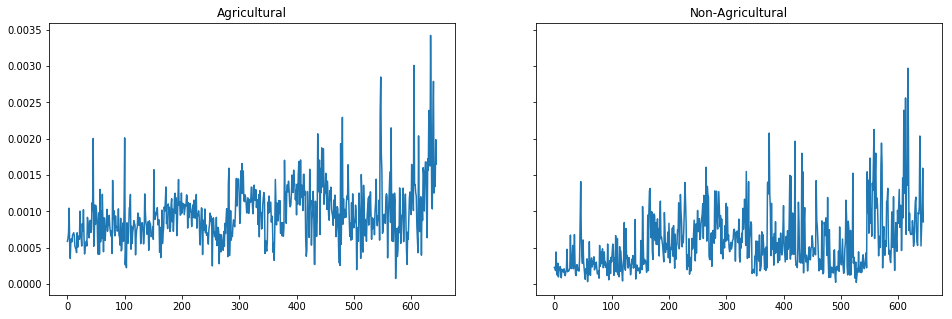

In [36]:
plotANA(wages) # before

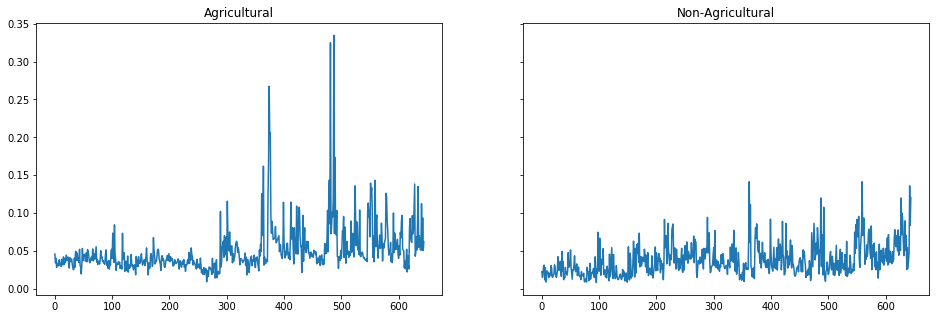

In [37]:
plotANA(newWages) # after

# Part 2: Space

## Moving probabilities

In [38]:
def computeMovingProbs(wages):
    
    theta_h, theta_l = computeTheta(wages)
    Theta = np.expand_dims(np.vstack([theta_l, theta_h]), 0)
    expectedUtility = myGamma(param.zeta)*Theta
    
    constant = myGamma(param.eta/param.zeta)/param.eta * psi(param.r)**(param.eta-1)
    
    # since the interest rate is a constant, we can take psi(r_{t+1}) to be a constant too
    W_rt = constant * expectedUtility**param.eta + amenities[1] # amenities in 1910

    # tau is indexed like j x r
    stuff = np.expand_dims(W_rt, 2) - tau
    rho = np.exp(1/param.kappa * stuff)
    
    # and we normalize
    sums = np.sum(rho, axis=3) # across the R's, not the j's
    sums = np.expand_dims(sums, axis=3)

    movingProbs = rho/sums
    return movingProbs


def newLocations(skills, wages):
    """
    updates the new locations
    """
    movingProbs = computeMovingProbs(wages)
    oldL = np.expand_dims(skills, axis=3)
    new = np.sum(movingProbs * oldL, axis=2)
    
    return new

newSkills = newLocations(skills, wages)
np.sum(newSkills, axis=R) # note that the overall lambda stays the same... since we didn't change that part

array([[0.7046579 , 0.29534209]])

In [39]:
movingProbs = computeMovingProbs(newWages)
movingProbs.shape

(1, 2, 645, 645)

In [40]:
# since it's the people moving from region j --> r
# the probabilities of \sum_r \rho_{jr} = 1
np.sum(movingProbs, 3)

array([[[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.]]])

## Iteratively guessing better spatial allocations?

L---- #0: 0.00040877856260008967
L---- #10: 0.00011676810101736211
L---- #20: 5.581780114302243e-05
L---- #30: 3.5775218442432886e-05
L---- #40: 2.7542176977562167e-05
L---- #50: 2.359596174654601e-05
L---- #60: 2.1428626621971375e-05
L---- #70: 2.0057650258301877e-05
L---- #80: 1.9057380942262934e-05
L---- #90: 1.823312865577739e-05
L---- #100: 1.7491078117824877e-05
L---- #110: 1.678489137000674e-05
L---- #120: 1.6098838308641133e-05
L---- #130: 1.5422985249494483e-05
L---- #140: 1.4756275943994763e-05
L---- #150: 1.4100436246627319e-05
L---- #160: 1.3458687308266813e-05
L---- #170: 1.2830908388319415e-05
L---- #180: 1.222054354377535e-05
L---- #190: 1.1628497457230845e-05
L---- #200: 1.1056279653938469e-05
L---- #210: 1.0504818898356304e-05
L---- #220: 9.974590607240671e-06
L---- #230: 9.465788117687256e-06
L---- #240: 8.97837683485697e-06
L---- #250: 8.512141614748454e-06
L---- #260: 8.066727407893514e-06
L---- #270: 7.641673130828168e-06
L---- #280: 7.236439328719506e-06
L---- #29

Text(0,0.5,'log high-skill')

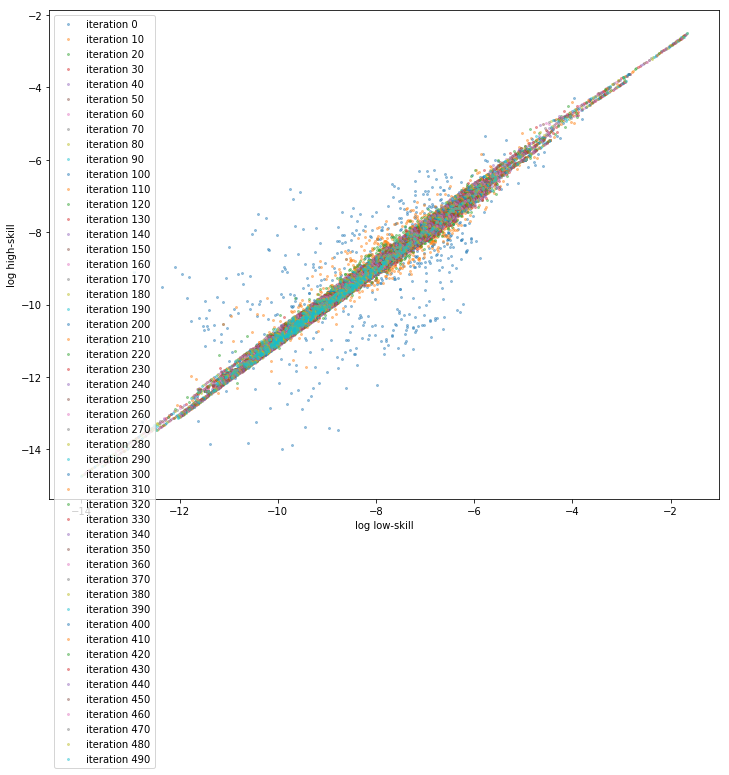

In [41]:
# init
wages  = np.ones_like(readWages())
skills = readSkills()

plt.figure(figsize=(12,9))

lr = 0.2
losses = []
labels = []

# loop
for i in range(500):
    
    # find a fixed point wage, given location
    wages = loopy(skills, wages, log=False)
    
    # find the new locations, given the wage
    newSkills = newLocations(skills, wages)
    
    loss = np.sum((newSkills - skills)**2)
    losses.append(loss)
    
    skills = lr * newSkills + (1-lr)*skills
    
    if loss < 1e-6:
        print('L---- #{}: {}'.format(i, loss))
        break
    
    if i % 10 == 0:
        print('L---- #{}: {}'.format(i, loss))
        drawLog(skills)
        labels.append('iteration {}'.format(i))


plt.legend(labels)
plt.xlabel('log low-skill'); plt.ylabel('log high-skill')

Text(0.5,0,'Fraction of stayers 1880-1910')

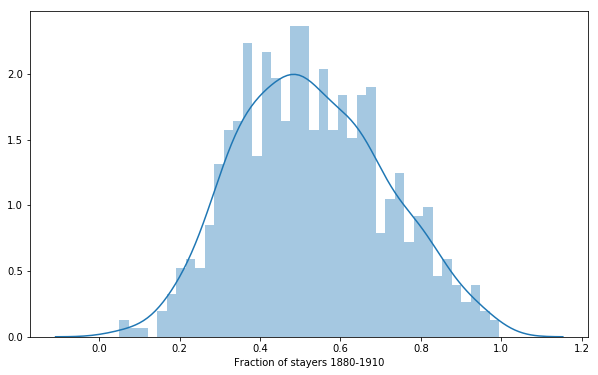

In [78]:
x= computeMovingProbs(wages)

import seaborn as sns
fig, ax = plt.subplots(1, figsize=(10,6))
sns.distplot(np.diag(x[0,A]), bins=40, ax=ax)
plt.xlabel("Fraction of stayers 1880-1910")

In [42]:
wages[t,A,:10]

array([0.09635706, 0.06839023, 0.07355093, 0.05255794, 0.05590023,
       0.07406192, 0.05768265, 0.07795101, 0.07146844, 0.04804815])

In [43]:
wages[t,NA,:10]

array([0.03958034, 0.02386189, 0.03433264, 0.04809145, 0.04582229,
       0.02033518, 0.04535709, 0.01495286, 0.02167294, 0.03057256])

In [44]:
computePrices(wages)

array([1.19063439, 0.99999102])

In [45]:
np.sum(skills, axis=1).shape

(1, 645)

In [46]:
skills[t,:,:10]

array([[1.53896727e-04, 9.17687395e-05, 4.23929686e-05, 1.86726313e-04,
        1.41690524e-04, 3.07878963e-05, 2.92925948e-04, 4.13569466e-05,
        4.68654293e-05, 3.03190971e-04],
       [5.52408007e-05, 3.22767277e-05, 1.56549618e-05, 7.63537507e-05,
        5.75090928e-05, 1.08975695e-05, 1.18532441e-04, 1.40668035e-05,
        1.65715878e-05, 1.15267332e-04]])

In [47]:
tau[0]

array([-1.6331  ,  0.18976 ,  0.19459 ,  0.31312 ,  0.30562 ,  0.36967 ,
        0.43369 ,  0.16765 ,  0.22013 ,  0.30779 ,  0.26163 ,  0.38573 ,
        0.095056,  0.13842 ,  0.22614 ,  0.33882 ,  0.28397 ,  0.2027  ,
        0.38757 ,  0.52996 ,  0.66071 ,  0.54632 ,  0.76132 ,  0.7096  ,
        0.56739 ,  0.63827 ,  0.71214 ,  0.82603 ,  0.90886 ,  0.90996 ,
        0.62924 ,  0.52131 ,  0.77443 ,  0.87537 ,  0.76816 ,  1.408   ,
        1.2998  ,  1.3764  ,  1.2606  ,  1.34    ,  1.3418  ,  1.4898  ,
        1.4383  ,  1.5931  ,  1.5308  ,  1.4625  ,  1.5604  ,  1.6757  ,
        1.5954  ,  1.6554  ,  1.7836  ,  1.7174  ,  1.5344  ,  1.4482  ,
        1.6369  ,  1.6799  ,  1.6109  ,  1.7476  ,  1.4659  ,  1.4316  ,
        1.54    ,  1.4638  ,  1.3477  ,  1.3239  ,  0.28046 ,  0.35844 ,
        0.29892 ,  0.18506 ,  0.47945 ,  0.38388 ,  1.2352  ,  1.2089  ,
        1.3606  ,  1.0002  ,  1.0637  ,  0.89545 ,  1.0681  ,  0.96655 ,
        1.059   ,  1.1453  ,  1.2514  ,  0.6465  , 

In [48]:
1.4e-4

0.00014

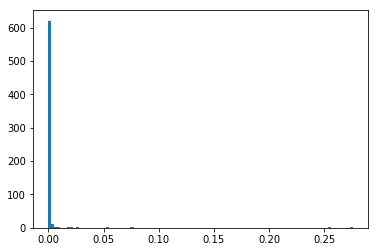

In [49]:
plt.hist(np.sum(skills, axis=1)[0], bins=100)
plt.show()

In [50]:
pop1880 = readSkills()

lambd, people, skillshare = computeLrt(pop1880)
people[t,1] * skillshare[t,L,1]

0.0011736

In [51]:
np.set_printoptions(precision=10)
np.set_printoptions(suppress=True)

print(Q[1, NA,:10])

[0.000068269  0.0000053458 0.00001162   0.0002448    0.00014929
 0.0000008663 0.00029289   0.00000029   0.0000017686 0.000060426 ]


In [52]:
Z[1]

array([0.067368, 0.084494])

In [53]:
amenities[1]

array([-0.060319 , -0.1503   , -0.40841  ,  0.048286 , -0.018639 ,
       -0.47562  ,  0.1751   , -0.39783  , -0.34578  ,  0.21427  ,
        0.17662  ,  0.39831  , -0.47823  , -0.2363   ,  0.0033652,
       -0.51589  , -0.54557  , -0.081963 , -0.42398  ,  0.057818 ,
        0.33137  ,  0.26741  ,  0.096028 , -0.17262  ,  0.27879  ,
       -0.38818  , -0.096696 , -0.08257  ,  0.19684  , -0.26851  ,
       -0.20838  , -0.28163  ,  0.089316 , -0.090514 , -0.10465  ,
        0.1935   ,  0.20847  ,  0.18286  ,  0.14844  ,  0.060874 ,
        0.36651  ,  0.092097 , -0.050639 , -0.45743  ,  0.033578 ,
        0.027872 ,  0.6115   ,  0.45922  ,  0.46323  ,  0.12785  ,
        0.30156  ,  0.54064  ,  0.17787  , -0.55911  , -0.12933  ,
        0.52109  , -0.015145 , -0.36058  , -0.33324  ,  0.2935   ,
        0.017472 ,  0.30363  , -0.052314 , -0.1244   , -0.42168  ,
       -0.33914  , -0.35636  , -0.42592  , -0.31684  , -0.30757  ,
        0.09757  ,  0.14349  ,  0.53661  ,  0.016654 , -0.0652

.




## Are these the 1910 wages and locations?

In [54]:
GDP_1910 = computeGDP(skills, wages)
K_1910 = (1-psi(param.r)) * (1-param.alpha) * GDP_1910
capitalRentalRate = GDP_1910/K_1910 * param.alpha 
capitalRentalRate - param.delta # should match param.r

-0.6935790530942079

In [55]:
param.r

2.8866

Text(0,0.5,'log manufacturing earnings 1910')

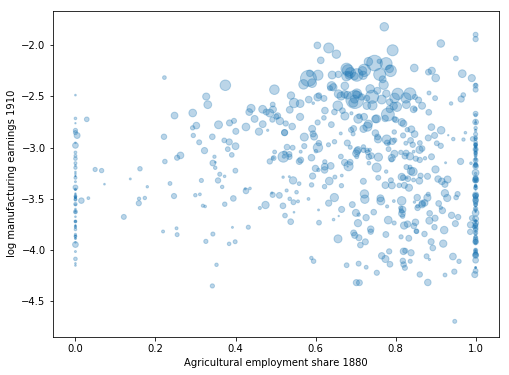

In [56]:
# Figure 3 in the paper
# agricultural employment share 1880 vs log Manufacturing earnings 1910
oldSkills=readSkills()
lamda, Lrt, lam_rt = computeLrt(oldSkills) # 1880
sizes = np.floor(Lrt[0]**0.6 * 2000)

plt.figure(figsize=(8,6))
plt.scatter(lam_rt[t,A], np.log(priceNormalize(wages)[t,NA]), alpha=0.3, s=sizes)
plt.xlabel('Agricultural employment share 1880')
plt.ylabel('log manufacturing earnings 1910')